# Analisis Explotario y Ingenieria de Caracteristicas
### Nombre: Eduardo Arce, Esteban Cordova

### Importación de modulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
import joblib


# Configuración estética
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
print("Modulos importados")

/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-21 21:25:40.364505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 21:25:40.364547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 21:25:40.365631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 21:25:40.371850: I tensorflow/core/platform/cpu_feature_guard.cc:18

Modulos importados


 ## 1. Carga inicial del dataset
### Vistazo inicial al mismo

In [2]:
# Cargar el dataset
df = pd.read_csv("test_set_1.csv")

# Vista inicial
df.head()

,userId,movieId,rating,timestamp
0,66954,780,3.0,850944100
1,9877,566,3.0,945497442
2,38348,1086,4.0,999975049
3,177202,1020,4.0,948169041
4,140400,275079,3.5,1653782463


## 2. Información general del DataFrame

Obtenemos una descripción básica de la estructura del dataset, incluyendo:

- El número total de registros (filas)
- Las columnas presentes en el dataset
- El tipo de dato de cada columna (`int64`, `float64`, `object`, etc.)
- La cantidad de valores no nulos por columna

Esta información es útil para detectar la presencia de valores faltantes, identificar columnas mal tipadas (por ejemplo fechas como `object`), y verificar que la estructura general sea coherente antes de proceder con el análisis.


In [3]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333368 entries, 0 to 5333367
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 162.8 MB


## 3. Estadísticas descriptivas

Obtenemos estadísticas resumidas de las columnas numéricas, como la media, mediana, mínimo, máximo y desviación estándar. Esto ayuda a entender la dispersión, sesgo y rangos típicos de los datos numéricos, especialmente del `rating`.


In [4]:
# Estadísticas descriptivas
df.describe()

,userId,movieId,rating,timestamp
count,5.333368e+06,5.333368e+06,5.333368e+06,5.333368e+06
mean,1.003232e+05,2.932297e+04,3.540315e+00,1.275147e+09
std,5.795290e+04,5.096274e+04,1.059116e+00,2.561771e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,8.228736e+08
25%,5.014500e+04,1.232000e+03,3.000000e+00,1.050908e+09
50%,1.003430e+05,3.461000e+03,3.500000e+00,1.272265e+09
75%,1.505050e+05,4.419900e+04,4.000000e+00,1.503066e+09
max,2.009480e+05,2.927550e+05,5.000000e+00,1.697164e+09


## 4. Métricas generales del dataset

Calculamos algunas métricas clave para tener una visión general del conjunto:

- Total de usuarios y películas únicos, lo que da una idea del tamaño del sistema.
- Estadísticas básicas de los ratings (mínimo, máximo y promedio).
- Rango temporal de las calificaciones, útil para detectar si hay sesgos de época o cambios en el comportamiento del usuario a lo largo del tiempo.


In [5]:
# Estadisticas varias
# Número de usuarios y películas únicos
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

# Estadísticas de ratings
rating_min = df['rating'].min()
rating_max = df['rating'].max()
rating_mean = df['rating'].mean()

# Rango de tiempo (de timestamp a fecha)
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
date_min = df['date'].min()
date_max = df['date'].max()

# Mostrar resultados
print(f'Usuarios únicos: {num_users:,}')
print(f'Películas únicas: {num_movies:,}')
print(f'Rating mínimo: {rating_min}')
print(f'Rating máximo: {rating_max}')
print(f'Rating promedio: {rating_mean:.2f}')
print(f'Rango temporal: {date_min.date()} → {date_max.date()}')

Usuarios únicos: 200,384
Películas únicas: 50,879
Rating mínimo: 0.5
Rating máximo: 5.0
Rating promedio: 3.54
Rango temporal: 1996-01-29 → 2023-10-13


# Visualización

## 5. Distribución de calificaciones

Visualizamos la distribución de las calificaciones para identificar posibles sesgos. Es común en datasets como MovieLens observar una concentración en valores altos (por ejemplo, 4.0 o 5.0), lo cual puede influir en los modelos de recomendación.

El uso de KDE (`kde=True`) permite suavizar la curva y observar mejor la forma general de la distribución.


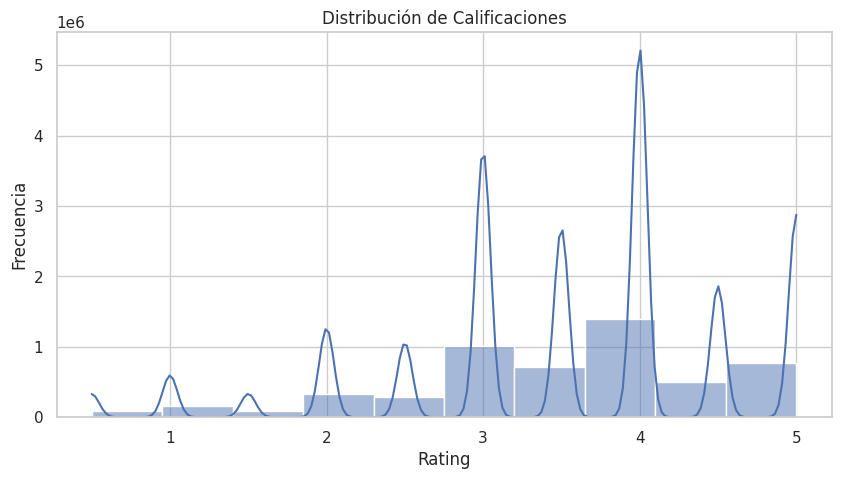

In [6]:
# Distribución de calificaciones
sns.histplot(df['rating'], bins=10, kde=True)
plt.title("Distribución de Calificaciones")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

## 6. Actividad de los usuarios

Se analiza cuántas calificaciones ha hecho cada usuario. El boxplot permite identificar la dispersión de esta actividad y detectar usuarios muy activos (outliers) que califican muchas más películas que el promedio.

Esto es útil para entender la densidad del dataset y evaluar si existen usuarios que podrían influir desproporcionadamente en los modelos.


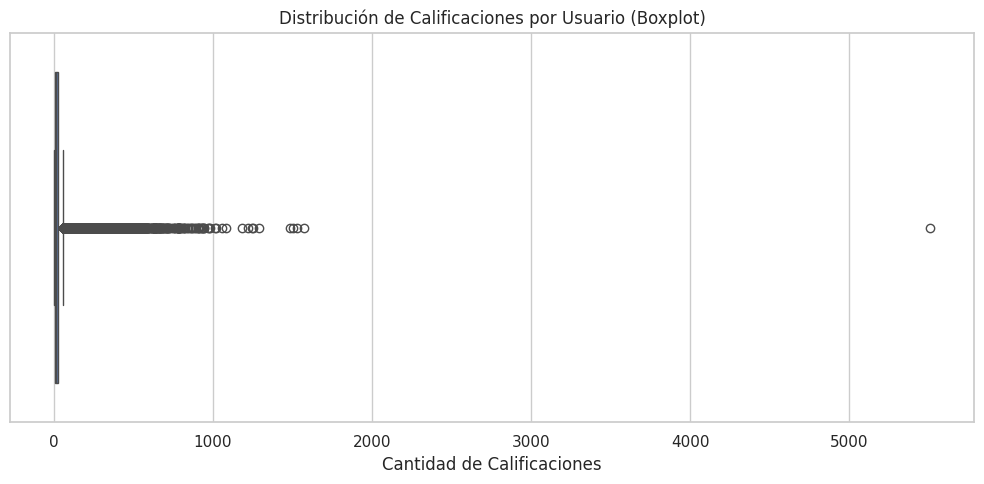

In [7]:
user_counts = df['userId'].value_counts()
sns.boxplot(x=user_counts)
plt.title("Distribución de Calificaciones por Usuario (Boxplot)")
plt.xlabel("Cantidad de Calificaciones")
plt.tight_layout()
plt.show()


### Observaciones del gráfico

El boxplot revela una fuerte asimetría en la cantidad de calificaciones por usuario. La gran mayoría califica menos de 200 películas, mientras que unos pocos usuarios extremos llegan a superar las 5000. Este patrón de largo extremo es característico de datasets de comportamiento humano en sistemas de recomendación, y es importante considerarlo al entrenar modelos, ya que estos usuarios outlier pueden influir de forma desproporcionada.


## 7. Distribución de usuarios con baja actividad

Se analiza en detalle el subconjunto de usuarios que realizaron 200 o menos calificaciones. Esta visualización permite observar con mayor claridad la distribución en la "cola corta" del boxplot anterior, donde se concentra la mayoría de usuarios.

Este tipo de análisis ayuda a identificar patrones en usuarios poco activos, quienes suelen representar el mayor volumen en sistemas reales y pueden afectar la calidad de las recomendaciones personalizadas.


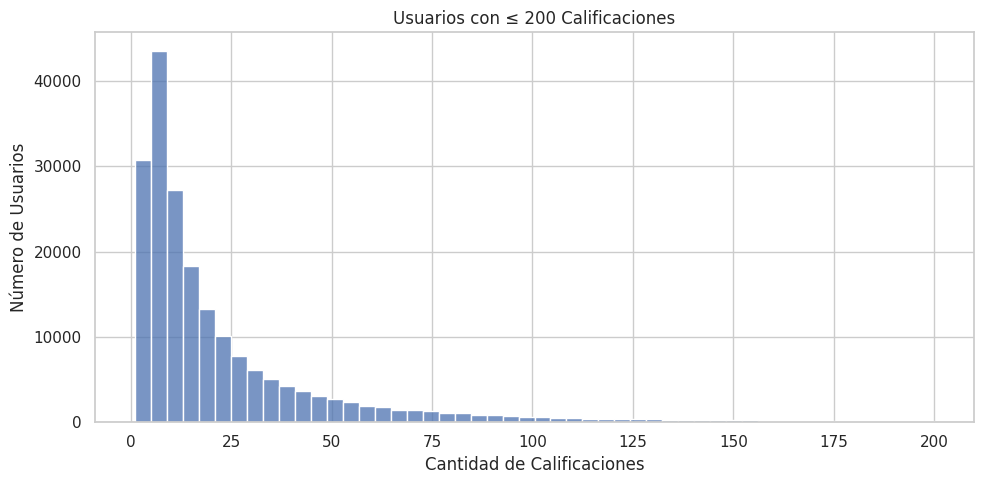

In [ ]:
user_counts_trimmed = user_counts[user_counts <= 200]
sns.histplot(user_counts_trimmed, bins=50, kde=False)
plt.title("Usuarios con ≤ 200 Calificaciones")
plt.xlabel("Cantidad de Calificaciones")
plt.ylabel("Número de Usuarios")
plt.tight_layout()
plt.show()


## 8. Actividad por película

El boxplot muestra la cantidad de calificaciones recibidas por cada película. Al igual que en el caso de los usuarios, observamos una distribución asimétrica, donde pocas películas concentran una gran cantidad de ratings, mientras que la mayoría reciben solo unos pocos.

Esto refleja un fenómeno típico en sistemas de recomendación: una minoría de ítems son muy populares, mientras que muchos otros tienen baja exposición (problema de "larga cola").


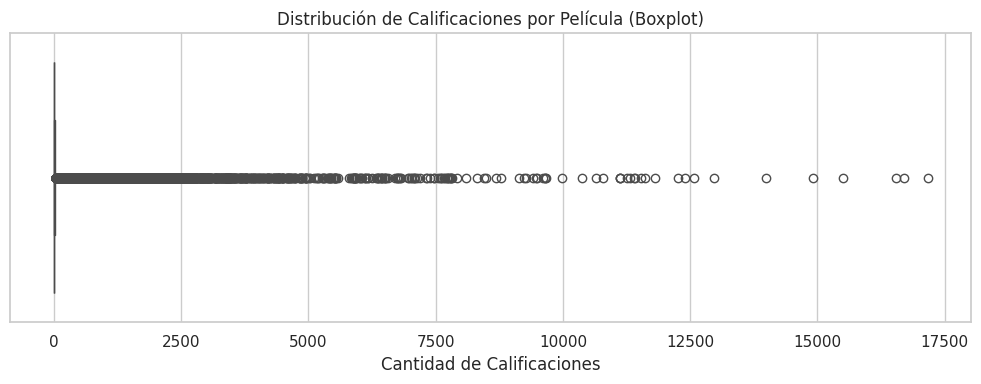

In [9]:
movie_counts = df['movieId'].value_counts()
plt.figure(figsize=(10, 4))
sns.boxplot(x=movie_counts)
plt.title("Distribución de Calificaciones por Película (Boxplot)")
plt.xlabel("Cantidad de Calificaciones")
plt.tight_layout()
plt.show()

## 9. Películas con baja cantidad de calificaciones

Se analiza el subconjunto de películas que han recibido 100 o menos calificaciones. Este tipo de visualización permite enfocarse en la mayoría silenciosa del catálogo: películas que apenas han sido vistas o valoradas.

Es importante tener en cuenta esta baja interacción al momento de entrenar modelos, ya que estas películas suelen tener datos insuficientes para generar buenas recomendaciones (problema de *cold start*).


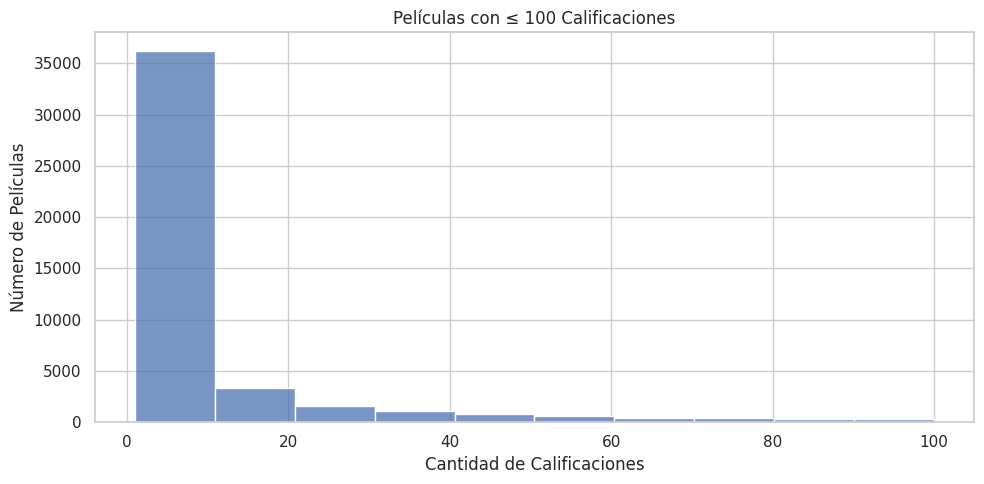

In [10]:
movie_counts_trimmed = movie_counts[movie_counts <= 100]

plt.figure(figsize=(10, 5))
sns.histplot(movie_counts_trimmed, bins=10, kde=False)
plt.title("Películas con ≤ 100 Calificaciones")
plt.xlabel("Cantidad de Calificaciones")
plt.ylabel("Número de Películas")
plt.tight_layout()
plt.show()

## 10. Evolución temporal de las calificaciones

Se transforma el timestamp a formato de fecha para analizar cómo ha evolucionado la cantidad de calificaciones a lo largo del tiempo. 

La distribución por año permite identificar posibles aumentos en la actividad de los usuarios, cambios en el uso de la plataforma o periodos anómalos que podrían requerir un tratamiento especial.


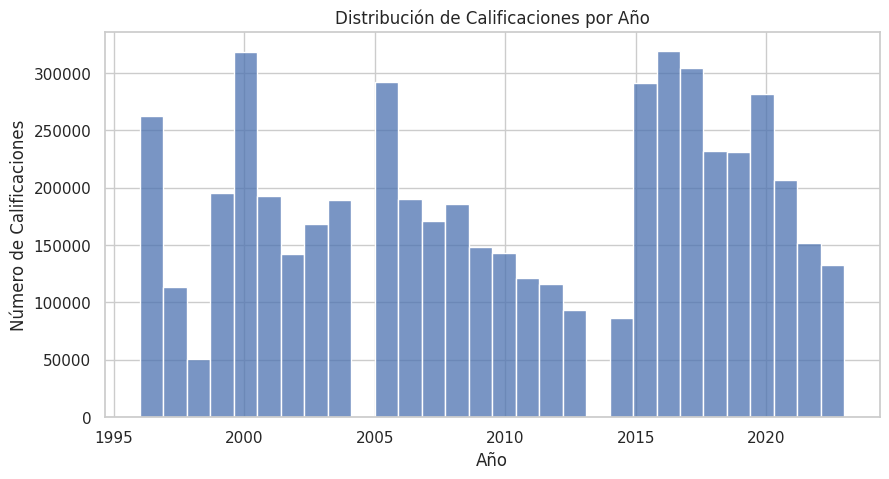

In [11]:
# Conversión de timestamp a fecha
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['date'].dt.year

# Evolución de calificaciones por año
sns.histplot(df['year'], bins=30, kde=False)
plt.title("Distribución de Calificaciones por Año")
plt.xlabel("Año")
plt.ylabel("Número de Calificaciones")
plt.show()

### 11. Usuarios con comportamiento extremo constante

Se identifican usuarios que califican exclusivamente con 5.0 o con 0.5. Este tipo de comportamiento sugiere perfiles con sesgo extremo, posiblemente poco útiles para modelos predictivos ya que no ofrecen variabilidad en sus preferencias.


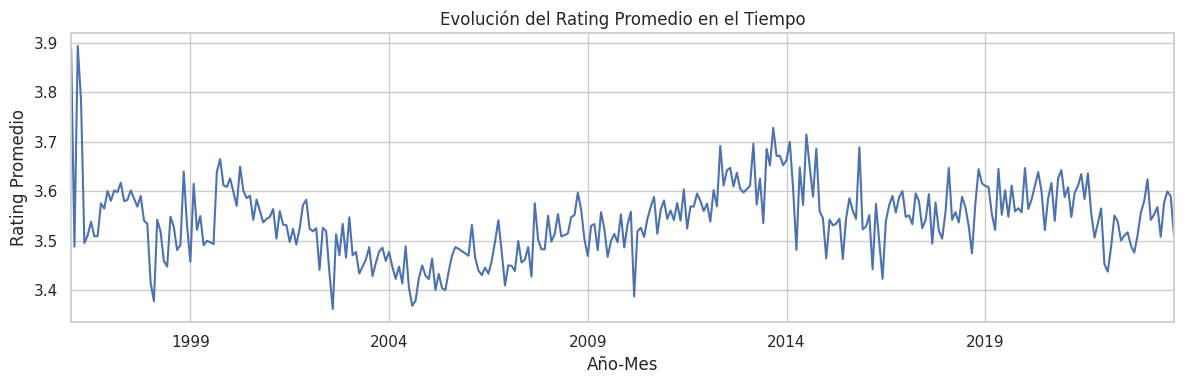

In [31]:
df['year_month'] = df['date'].dt.to_period('M')
monthly_avg = df.groupby('year_month')['rating'].mean()

monthly_avg.plot(figsize=(12, 4))
plt.title("Evolución del Rating Promedio en el Tiempo")
plt.xlabel("Año-Mes")
plt.ylabel("Rating Promedio")
plt.grid(True)
plt.tight_layout()
plt.show()


### 12. Usuarios extremadamente activos (Z-score)

Aplicando Z-score al número de calificaciones por usuario, se detectan aquellos usuarios cuyo comportamiento es estadísticamente extremo. Este análisis cuantitativo complementa los boxplots anteriores, identificando outliers en términos de volumen de interacción.


In [37]:
from scipy.stats import zscore

user_rating_counts = df['userId'].value_counts()
z_scores = zscore(user_rating_counts)

outlier_users_z = user_rating_counts[z_scores > 3]  # Z > 3 como umbral común

print(f"Usuarios extremadamente activos (Z-score > 3): {len(outlier_users_z)}")


Usuarios extremadamente activos (Z-score > 3): 3541


## 13. Dispersión de interacciones (Sparsity)

Se visualiza la matriz de interacciones entre usuarios y películas para evidenciar el grado de dispersión de los datos.

Como es común en sistemas de recomendación, la matriz es extremadamente dispersa: la mayoría de los usuarios han calificado solo una pequeña fracción del catálogo. Esto refuerza la necesidad de usar técnicas robustas ante datos escasos (como filtrado colaborativo, modelos basados en embeddings, etc.).


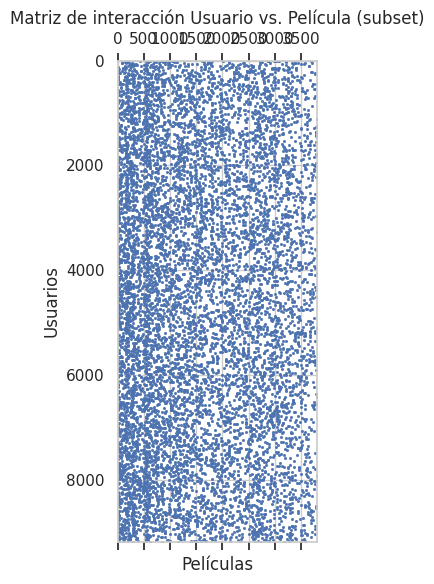

In [32]:
sample = df.sample(10000)  # Subset para eficiencia
pivot = sample.pivot(index='userId', columns='movieId', values='rating').fillna(0)

plt.figure(figsize=(10, 6))
plt.spy(pivot, markersize=1)
plt.title("Matriz de interacción Usuario vs. Película (subset)")
plt.xlabel("Películas")
plt.ylabel("Usuarios")
plt.tight_layout()
plt.show()


# Analisis estadistico

## 14. Análisis estadístico general

Se resumen las estadísticas descriptivas de las calificaciones (`rating`), como el promedio, los valores mínimo y máximo, así como la desviación estándar, que indica el grado de variabilidad en las opiniones de los usuarios.

También se identifican:
- El número total de usuarios y películas únicos.
- La película con más y menos calificaciones (ítems extremos en popularidad).
- El usuario más activo (con mayor número de ratings) y el menos activo.

Estos datos permiten tener una visión global del comportamiento de interacción dentro del dataset.


In [12]:
# Estadísticas generales del rating
rating_stats = df['rating'].describe()
print("Estadísticas de Ratings:")
print(rating_stats)

# Desviación estándar
std_rating = df['rating'].std()
print("\nDesviación estándar del rating:", round(std_rating, 4))

# Número total de usuarios únicos
num_users = df['userId'].nunique()
print("\nTotal de usuarios únicos:", num_users)

# Número total de ítems únicos
num_items = df['movieId'].nunique()
print("Total de películas únicas:", num_items)

# Ítem más consumido
top_item = df['movieId'].value_counts().idxmax()
top_item_count = df['movieId'].value_counts().max()
print("\nPelícula más calificada:", top_item, "con", top_item_count, "calificaciones")

# Ítem menos consumido
bottom_item = df['movieId'].value_counts().idxmin()
bottom_item_count = df['movieId'].value_counts().min()
print("Película menos calificada:", bottom_item, "con", bottom_item_count, "calificación")

# Usuario más activo
top_user = df['userId'].value_counts().idxmax()
top_user_count = df['userId'].value_counts().max()
print("\nUsuario más activo:", top_user, "con", top_user_count, "ratings")

# Usuario menos activo
bottom_user = df['userId'].value_counts().idxmin()
bottom_user_count = df['userId'].value_counts().min()
print("Usuario menos activo:", bottom_user, "con", bottom_user_count, "rating")


Estadísticas de Ratings:
count    5.333368e+06
mean     3.540315e+00
std      1.059116e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Desviación estándar del rating: 1.0591

Total de usuarios únicos: 200384
Total de películas únicas: 50879

Película más calificada: 318 con 17162 calificaciones
Película menos calificada: 189869 con 1 calificación

Usuario más activo: 175325 con 5507 ratings
Usuario menos activo: 82023 con 1 rating


## 15. Correlación entre variables numéricas

Aunque el dataset cuenta con pocas variables numéricas, se explora la relación entre `rating` y `timestamp` (momento de la calificación).

Este análisis permite detectar si existe alguna relación temporal en la forma de calificar, como una tendencia a puntuar más bajo o más alto en ciertas épocas. La ausencia de correlación también puede ser un hallazgo relevante.


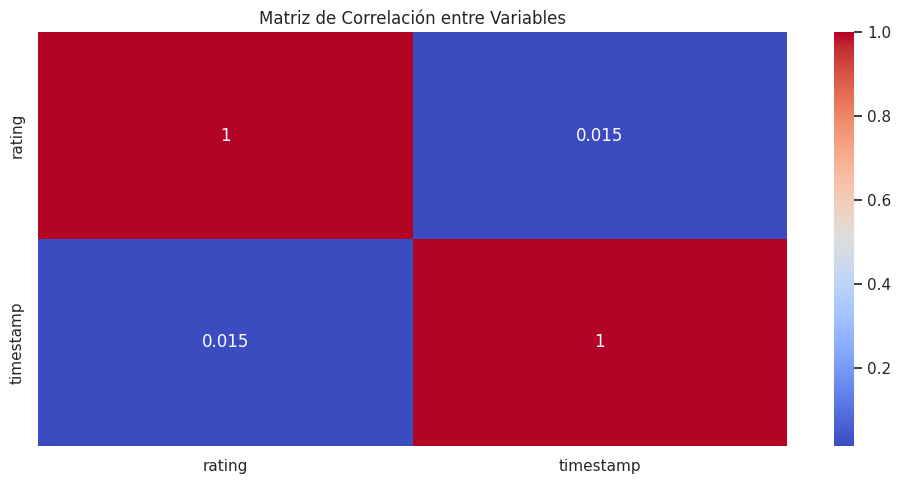

In [33]:
corr_matrix = df[['rating', 'timestamp']].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación entre Variables")
plt.tight_layout()
plt.show()


# Analisis de outliers

## 16. Detección de outliers en comportamiento de usuarios

Se identifican usuarios que han otorgado siempre la misma calificación. Este tipo de comportamiento puede indicar perfiles con sesgo extremo o datos no fiables (por ejemplo, bots, usuarios poco activos o con uso atípico del sistema).

Además, se analiza qué valor específico usaron estos usuarios únicos: muchos de ellos tienden a calificar exclusivamente con 5.0 (valor máximo), lo cual podría sesgar el promedio general si no se controla adecuadamente.

Este análisis permite anticipar la necesidad de filtrar, ponderar o tratar de forma especial estos casos en etapas posteriores del modelado.


In [13]:
# Usuarios que solo usan una calificación
user_rating_unique_counts = df.groupby('userId')['rating'].nunique()

# Usuarios que solo votan con 1 calificación única (posible outlier)
outlier_users = user_rating_unique_counts[user_rating_unique_counts == 1]
print(f"Usuarios que solo usan un mismo valor de rating: {len(outlier_users)}")

# ¿Qué calificación específica usaron?
outlier_details = df[df['userId'].isin(outlier_users.index)].groupby('userId')['rating'].first().value_counts()
print("Distribución de rating único entre los outliers:")
print(outlier_details)

# Usuarios que solo dan calificaciones altas o bajas (por ejemplo, solo 5.0 o solo 0.5)
only_high = outlier_details.get(5.0, 0)
only_low = outlier_details.get(0.5, 0)


Usuarios que solo usan un mismo valor de rating: 7104
Distribución de rating único entre los outliers:
rating
5.0    2809
4.0    1750
3.0    1316
4.5     388
3.5     295
2.0     174
1.0     113
2.5     105
0.5     105
1.5      49
Name: count, dtype: int64


### 17. Outliers en la distribución general de ratings

Se visualiza el boxplot de todos los ratings. Aunque el rango está acotado entre 0.5 y 5.0, este gráfico permite observar la distribución general, acumulaciones en los extremos y confirmar si existen valores atípicos concentrados (como una sobrerrepresentación del 5.0).


In [36]:
# Usuarios que solo usan ratings máximos
only_5_users = df.groupby('userId')['rating'].apply(lambda x: x.nunique() == 1 and x.iloc[0] == 5.0)
only_0_5_users = df.groupby('userId')['rating'].apply(lambda x: x.nunique() == 1 and x.iloc[0] == 0.5)

print(f"Usuarios que solo dan 5.0: {only_5_users.sum()}")
print(f"Usuarios que solo dan 0.5: {only_0_5_users.sum()}")


Usuarios que solo dan 5.0: 2809
Usuarios que solo dan 0.5: 105


# Clustering

## 18. Segmentación de usuarios (K-means Clustering)

Se aplica un modelo de clustering no supervisado (K-means) para identificar grupos de usuarios según su comportamiento general: promedio de calificaciones y cantidad total de interacciones.

Esto permite clasificar a los usuarios en segmentos como:
- Críticos (bajo promedio de rating)
- Generosos (alto promedio)
- Moderados
- Activos vs. pasivos (según número de calificaciones)

Esta segmentación puede ser útil para personalizar estrategias de recomendación o analizar diferencias de comportamiento.


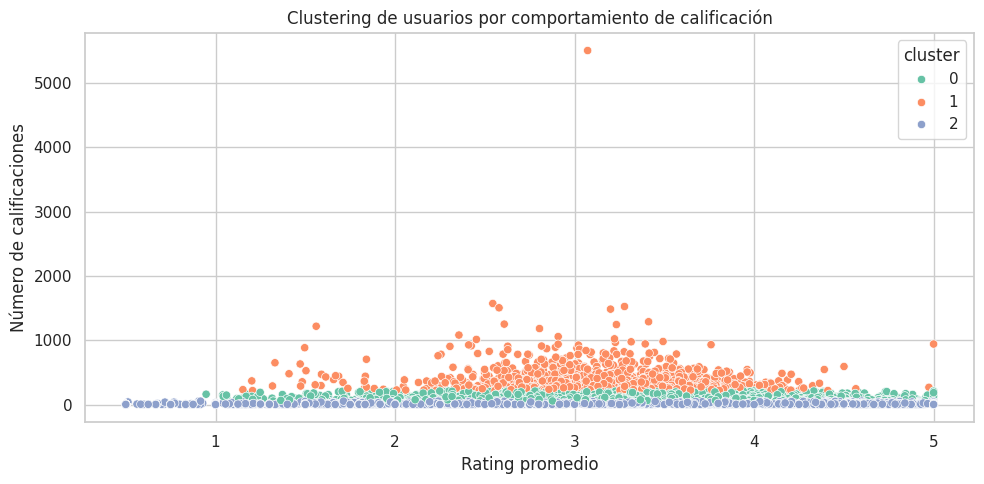

In [34]:
from sklearn.cluster import KMeans

user_profiles = df.groupby('userId')['rating'].agg(['mean', 'count']).reset_index()
user_profiles.columns = ['userId', 'avg_rating', 'num_ratings']

kmeans = KMeans(n_clusters=3, random_state=0)
user_profiles['cluster'] = kmeans.fit_predict(user_profiles[['avg_rating', 'num_ratings']])

sns.scatterplot(data=user_profiles, x='avg_rating', y='num_ratings', hue='cluster', palette='Set2')
plt.title("Clustering de usuarios por comportamiento de calificación")
plt.xlabel("Rating promedio")
plt.ylabel("Número de calificaciones")
plt.grid(True)
plt.tight_layout()
plt.show()


## 19. Conclusiones del Análisis Exploratorio

- La mayoría de los usuarios y películas tienen una baja actividad, lo cual sugiere una distribución de tipo "larga cola".
- Se identificaron usuarios atípicos que califican siempre con el mismo valor, especialmente con 5.0, lo que puede introducir sesgos.
- El análisis temporal mostró una evolución creciente en la actividad de calificación, con variaciones en la media de los ratings a lo largo del tiempo.
- El dataset presenta alta dispersión en la matriz de interacción usuario-película, lo cual podría requerir técnicas específicas como filtrado colaborativo basado en vecinos o modelos con embeddings.
- Estas observaciones son fundamentales para diseñar modelos de recomendación más robustos, considerando tanto los comportamientos mayoritarios como los extremos.


# Experimentos

In [14]:
# 🔹 2. Convertir timestamp
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

In [15]:
# 🔹 3. Codificar temporada, fin de semana y feriado
def get_season(month):
    if month in [12, 1, 2]:
        return 'invierno'
    elif month in [3, 4, 5]:
        return 'primavera'
    elif month in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'

df['season'] = df['month'].apply(get_season)

In [16]:
df['is_weekend'] = df['weekday'].isin([5, 6])


In [17]:
ecu_holidays = holidays.Ecuador(years=range(df['year'].min(), df['year'].max() + 1))
df['is_holiday'] = df['date'].isin(ecu_holidays)
print(df[['season', 'is_weekend', 'is_holiday']].describe(include='all'))

/tmp/ipykernel_36010/1763053412.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['date'].isin(ecu_holidays)


          season is_weekend is_holiday
count    5333368    5333368    5333368
unique         4          2          2
top     invierno      False      False
freq     1360697    3737820    5333366


In [18]:
# 🔹 4. Codificación booleana y categórica
df['season_encoded'] = df['season'].map({'invierno': 0, 'primavera': 1, 'verano': 2, 'otoño': 3})
df['is_weekend'] = df['is_weekend'].astype(int)
df['is_holiday'] = df['is_holiday'].astype(int)


In [19]:
# 🔹 5. Calcular rating_previous
df = df.sort_values(['userId', 'timestamp'])

In [20]:
# 🔹 Asegurar que week_of_year sea int para el merge
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

# 🔹 Calcular consumo semanal
consumo = df.groupby(['userId', 'week_of_year']).size().reset_index(name='consumo_semanal_usuario')
df = pd.merge(df, consumo, on=['userId', 'week_of_year'], how='left')



In [21]:
# 🔹 7. Ingeniería UMAP
temporal_features = ['year', 'month', 'weekday', 'season_encoded', 'is_weekend', 'is_holiday']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[temporal_features])
joblib.dump(scaler, "scaler_temporal2.pkl")  # ✅ ahora sí lo guardas correctamente

['scaler_temporal2.pkl']

In [22]:
# UMAP sobre muestra aleatoria
sample_size = 100_000
sample_idx = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]

In [23]:
reducer = umap.UMAP(n_components=3, random_state=42, init='random', n_neighbors=15, min_dist=0.1)
reducer.fit(X_sample)
X_umap_full = reducer.transform(X_scaled)
joblib.dump(reducer, 'umap_model2.pkl')


/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  

['umap_model2.pkl']

In [24]:
# Agregar latentes al dataframe
df[['temporal_1', 'temporal_2', 'temporal_3']] = X_umap_full

# 🔹 8. Seleccionar columnas finales para la RNN
columns_to_keep = [
    'userId', 'movieId',
    'temporal_1', 'temporal_2', 'temporal_3',
    'rating', 'timestamp',
    'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario'
]


In [25]:
df_rnn_final = df[columns_to_keep]

# 🔹 9. Guardar dataset final
df_rnn_final.to_csv("dataset_final_2.csv", index=False)
print("✅ Dataset RNN FINAL generado exitosamente.")

✅ Dataset RNN FINAL generado exitosamente.


In [26]:
import pandas as pd

# Ruta del archivo CSV
csv_path = "dataset_final_2.csv"

# Cargar el DataFrame
df_rnn_final = pd.read_csv(csv_path)

# Mostrar primeras filas para verificar
print("Datos cargados:")
print(df.head())

Datos cargados:
   userId  movieId  rating  timestamp                date  year  month  \
0       1      541     5.0  943227521 1999-11-21 23:38:41  1999     11   
1       1      166     5.0  943228442 1999-11-21 23:54:02  1999     11   
2       1     1784     1.0  943228545 1999-11-21 23:55:45  1999     11   
3       1     1944     2.0  943231120 1999-11-22 00:38:40  1999     11   
4       1     1208     5.0  943231192 1999-11-22 00:39:52  1999     11   

   weekday season  is_weekend  is_holiday  season_encoded  week_of_year  \
0        6  otoño           1           0               3            46   
1        6  otoño           1           0               3            46   
2        6  otoño           1           0               3            46   
3        0  otoño           0           0               3            47   
4        0  otoño           0           0               3            47   

   consumo_semanal_usuario  temporal_1  temporal_2  temporal_3  
0                      